# Emulated Hand Controller

## By Haris Naveed, Jash Narwani, and Robert Walsh

For this project our goal is to create a hand tracking and gesture recognition system in such a way that the gestures could be used as a replacement for a simple game controller.
In this case we intend to target the NES for our controller input

## Step 1: Hand Tracking

In order to do anything for this project, we first need a method to track our hands. We can do this by making use of the mediapipe and openCV packages

In [1]:
# here's our packages
import cv2
import mediapipe as mp

import copy

import matplotlib.pyplot as plt

In [2]:
# Before we get started proper, we should start by defining our hand detection model.
# Thankfully, mediapipe has a premade model specifically for finding and tracking hands, we can use it
hands = mp.solutions.hands.Hands()

In [3]:
# we need to also define our cv2 capturing method. Without it, we won't be able to track our hands at all. I hope you have a camera somewhere on your computer...
def videoCapture():
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("No camera, that sucks")
        return None
    
    return cap

def endCapture(cap):
    cap.release()
    
    cv2.destroyAllWindows()

In [4]:
# use this to identify our hands
def findHand(frame, margin, hands):
    # mediapipe uses RGB to find hands, cv2 captures BGR for some reason
    # we correct this
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # use the mediapipe hands model to identify our hand and keypoints
    results = hands.process(img)
    cutFrame = None

    # mediapipe normalizes coordinates, use capture size to fix that for later
    h, w, c = img.shape

    # if a hand is identified...
    if results.multi_hand_landmarks:
        # get the landmarks of the first hand
        hand1 = results.multi_hand_landmarks[0]
        Xs = []
        Ys = []
        # denormalize the coordinates of each landmark
        for landmark in hand1.landmark:
            cx, cy = int(landmark.x * w), int(landmark.y * h)
            Xs.append(cx)
            Ys.append(cy)

        # identify the bounds of our hand
        xmin = min(Xs)
        xmax = max(Xs)
        ymin = min(Ys)
        ymax = max(Ys)

        # crop the frame to only have our hand
        cutFrame = copy.deepcopy(frame[max(0, ymin-margin):min(frame.shape[0], ymax+margin), max(0, xmin-margin):min(frame.shape[1], xmax+margin)])

        cv2.rectangle(frame, (max(0, xmin-margin), max(0, ymin-margin)), (min(frame.shape[1], xmax+margin), min(frame.shape[0], ymax+margin)), (0, 255, 0), 2)

    # return the frame, and the cropped frame (if applicable)
    return frame, cutFrame

Let's give it a try. Try running the next cell with your hand in clear view of the camera

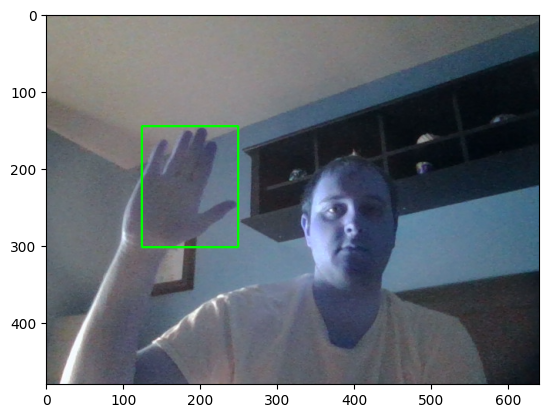

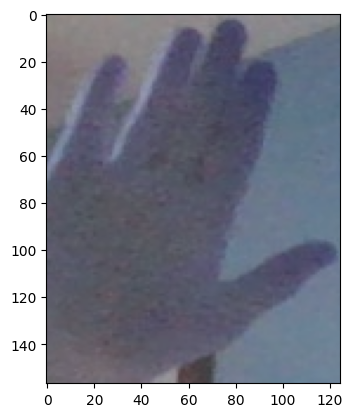

In [7]:
cap = videoCapture()

ret, frame = cap.read()

# Find the hand and get the cropped frame
frame, cutFrame = findHand(frame, 10, hands)

if cutFrame is not None:
    if cutFrame.shape[0] != 0 and cutFrame.shape[1] != 0:
        plt.imshow(frame)
        plt.show()
        plt.imshow(cutFrame)
        plt.show()

endCapture(cap)

With this working, we can now take these mediapipe cutouts and use them to predict controller inputs
Thankfully we already have a custom trained model that can do this, we just have to load it in

In [8]:
# import our custom model
from trainCustom import CNN
import torch

# helps us convert our captures into the format we need
from PIL import Image

import numpy as np

# use this to translate model outputs to keypresses
from pynput.keyboard import Key, Controller

In [9]:
# use this to predict our hands with the model
def predict_hand(cut_frame, model):
    cut_frame = Image.fromarray(cut_frame)
    image = cut_frame.convert('L')
    image = image.resize((128, 128))
    
    image = np.array(image)
    
    # comment this out if not using edge model
    # image = cv2.Canny(image, threshold1=100, threshold2=100)
    
    image = image.astype(np.float32) / 255.0

    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=0)

    image = torch.tensor(image, dtype=torch.float32)

    # Make the prediction
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)  # Get the class with the highest probability

    return predicted.item()  # Return the predicted class

Now it's understandable that it might be difficult to imagine what the model sees when you use it. After all, if we just cut out our hands, which can produce a variable size image, then the model is going to have problems, that's why we trim and cut up the image. Below, we can see that process to the hand you gave us earlier:

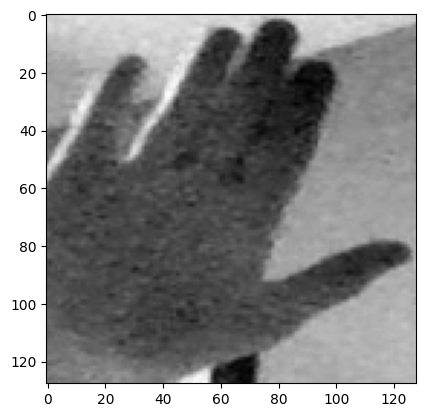

In [10]:
# take your image, convert it to grayscale, reshape it to 128x128, normalize it, and finally show it off
image = Image.fromarray(cutFrame)
image = image.convert('L')
image = image.resize((128, 128))

image = np.array(image)

# comment this out if not using edge model
# image = cv2.Canny(image, threshold1=100, threshold2=100)
    
image = image.astype(np.float32) / 255.0

plt.imshow(image, cmap='gray')
plt.show()

Now, obviously, the margins are much smaller on the actual image used by the model. The only thing the model can see is really just your hand and nothing around it.

Before we move on to our final step of trying to use the model to simulate a controller, we need to handle potential jitteryness from the model. Little differences on how you hand looks could possibly give bad readings and make inputs off. So we will be using a little bit of a rolling average to keep it somewhat consistent

In [11]:
class smoothInput:
    def __init__(self, size):
        self.size = size
        self.inputs = []
    
    def append(self, input):
        if len(self.inputs) >= self.size:
            self.inputs.pop(0)
        
        self.inputs.append(input)
    
    # when we need an input, get the input with the most amount
    def getInput(self):
        highestCount = 0
        count = 0
        for i in range(6):
            numCount = self.inputs.count(i)
            if numCount > count:
                highestCount = i
                count = numCount
            
            # if this count happens to be greater than half of the size, it is the default greatest
            if numCount >= len(self.inputs)/2:
                highestCount = i
                break
        
        return highestCount

With all of that complete, there is only one thing left to do, that is to try out the model

We should show what inputs are available. You should try to make one of 6 different hand signs. Thumbs up, Thumbs down, Point Down (back of hand facing camera), Point left (right hand), Point right (left hand), Point up (palm facing camera)

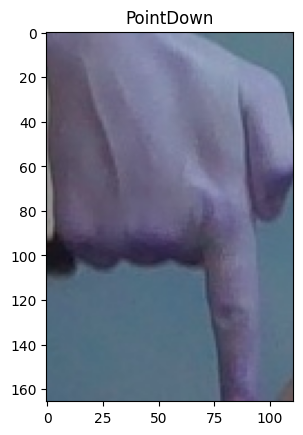

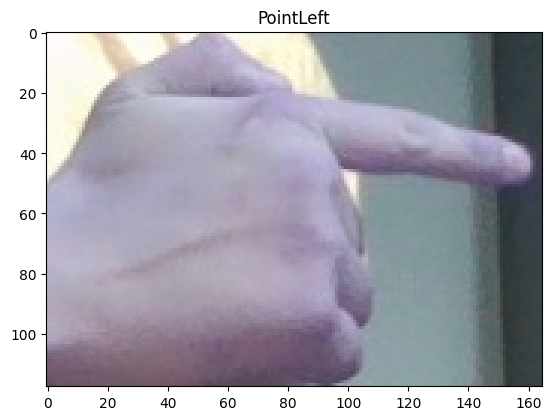

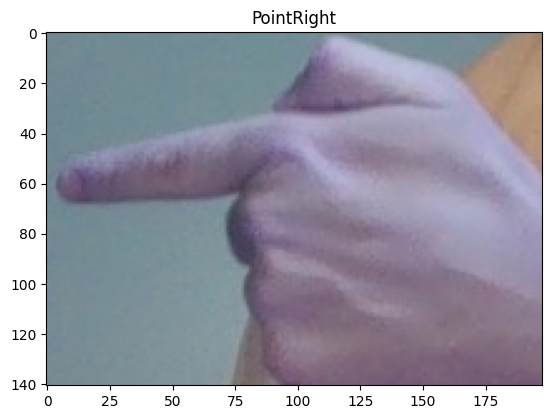

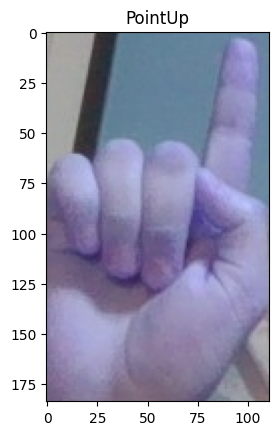

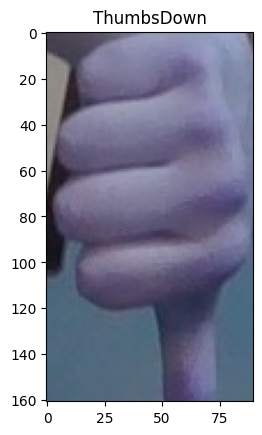

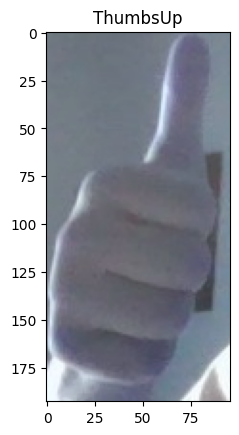

In [29]:
images = ["PointDown", "PointLeft", "PointRight", "PointUp", "ThumbsDown", "ThumbsUp"]

for image in images:
    savedImg = cv2.imread("ExampleData/{}.jpg".format(image))
    
    plt.imshow(savedImg)
    plt.title(image)
    plt.show()

Simply put, these hand gestures represent different possible inputs we can put into our simulated controller
### ThumbsUp = A
### ThumbsDown = B
### PointDir = DPAD

In [31]:
# Let's load our model now
model = CNN()
model.load_state_dict(torch.load("custom_model.pth"))

model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (finalPool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): 

In [33]:
import os

# Let's evaluate its accuracy from training
# Load dataset
print("Loading the dataset")

#0 = a, 1 = b, 2 = down, 3 = left, 4 = right, 5 = up
directories = ['a', 'b', 'down', 'left', 'right', 'up']

images = []
imageLabels = []
for i in range(len(directories)):
    for fileName in os.listdir("HandData/{}".format(directories[i])):
        image = Image.open(os.path.join("HandData/{}".format(directories[i]), fileName))
        image = np.array(image)
        
        image = image.astype(np.float32) / 255.0

        image = np.expand_dims(image, axis=0)
        image = np.expand_dims(image, axis=0)

        image = torch.tensor(image, dtype=torch.float32)
        
        images.append(image)
        
        imageLabels.append(i)

totalCount = len(imageLabels)
count = 0

for i in range(len(images)):
    output = model(images[i])
    _, predicted = torch.max(output, 1)
    prediction = predicted.item()
    
    if prediction == imageLabels[i]:
        count += 1


print("ACCURACY: {}".format(count/totalCount))    

Loading the dataset
ACCURACY: 0.9709273182957393


Now that we have evaluated the accuracy, let's use the model proper

In [40]:
# once again, start our captures
cap = videoCapture()

# create a smooth input
smooth = smoothInput(1)

# define our keyboard
keyboard = Controller()

# here is the margin value, we recommend keeping it at 10
margin = 10

currentOutput = 'x'

# keep running the algorithm until we cancel it
while True:
    ret, frame = cap.read()
    
    # did the camera stop working? End it
    if not ret:
        break

    # Find the hand and get the cropped frame
    frame, cutFrame = findHand(frame, margin, hands)
    
    if cutFrame is not None:
        if cutFrame.shape[0] != 0 and cutFrame.shape[1] != 0:
            # Display the cropped frame
            cv2.imshow("cutFrame", cutFrame)

            # Predict the class of the hand gesture
            predicted_class = predict_hand(cutFrame, model)
            
            smooth.append(predicted_class)
            
            actualOutput = smooth.getInput()
            
            print(f"Predicted Class: {predicted_class}, Smoothed Class: {actualOutput}")
            
            outputs = ['x', 'z', Key.down, Key.left, Key.right, Key.up]
            
            actualOutput = outputs[actualOutput]            
            
            if actualOutput != currentOutput:
                keyboard.release(currentOutput)
                keyboard.press(actualOutput)
                
                currentOutput = actualOutput
            
            # # the predicted class can then be translated into one of 6 inputs
            # if actualOutput == 0:
            #     keyboard.press('x')
            # elif actualOutput == 1:
            #     keyboard.press('z')
            # elif actualOutput == 2:
            #     keyboard.press(Key.down)
            # elif actualOutput == 3:
            #     keyboard.press(Key.left)
            # elif actualOutput == 4:
            #     keyboard.press(Key.right)
            # else:
            #     keyboard.press(Key.up)
            
    # Display the frame
    cv2.imshow("frame", frame)

    # Press 'q' to quit
    if cv2.waitKey(1) == ord('q'):
        break

endCapture(cap)

Predicted Class: 4, Smoothed Class: 4
Predicted Class: 2, Smoothed Class: 2
Predicted Class: 2, Smoothed Class: 2
Predicted Class: 2, Smoothed Class: 2
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 2, Smoothed Class: 2
Predicted Class: 4, Smoothed Class: 4
Predicted Class: 4, Smoothed Class: 4
Predicted Class: 4, Smoothed Class: 4
Predicted Class: 4, Smoothed Class: 4
Predicted Class: 4, Smoothed Class: 4
Predicted Class: 4, Smoothed Class: 4
Predicted Class: 4, Smoothed Class: 4
Predicted Class: 4, Smoothed Class: 4
Predicted Class: 5, Smoothed Class: 5
Predicted Class: 4, Smoothed Class: 4
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 3, Smoothed Class: 3
Predicted Class: 2, Smoothed Class: 2
Predicted Class: 2, Smoothed Class: 2
Predicted Cl

# AI Acknowledgement

As was said before, we are allowed to use Generative AI as long as we document to what extent we used it